# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from feature_engine.creation import CyclicalFeatures

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as mse

import scipy as sp
import scipy.fftpack

In [2]:
# load weekly sales dataset

try:
    filename = '../../Datasets/online_retail_dataset.csv'
    pd.read_csv(filename)
except FileNotFoundError:
    filename = '../code/Datasets/online_retail_dataset.csv'
    pd.read_csv(filename)

df = pd.read_csv(
    filename,
    usecols=['week', 'United Kingdom'],
    parse_dates=['week'],
    index_col=['week'],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


# Data analysis

First, explore the time series.

## Plot time series

<Axes: xlabel='week'>

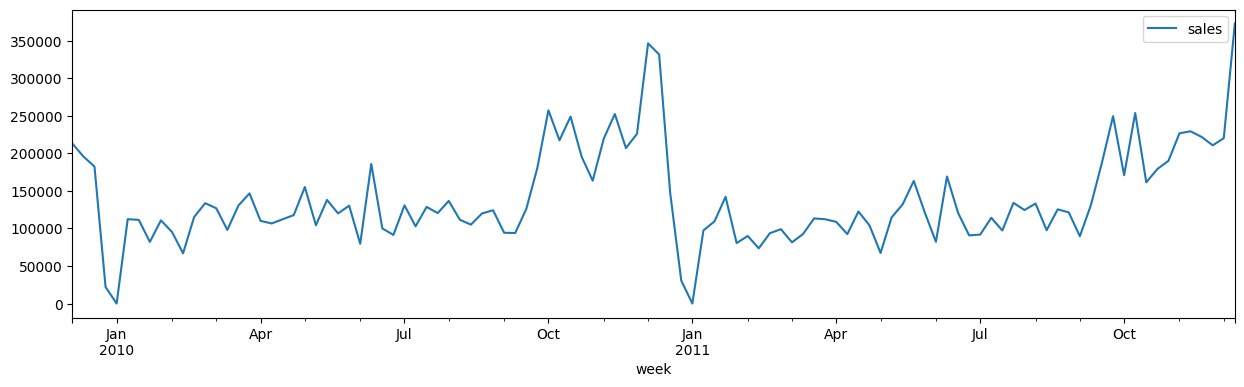

In [3]:
df.plot(figsize=[15, 4])

## Missing data

Check if there are missing values in the time series.

In [4]:
df.isnull().sum()

sales    0
dtype: int64

## Missing timestamps

Check if there are missing timestamps in the index.

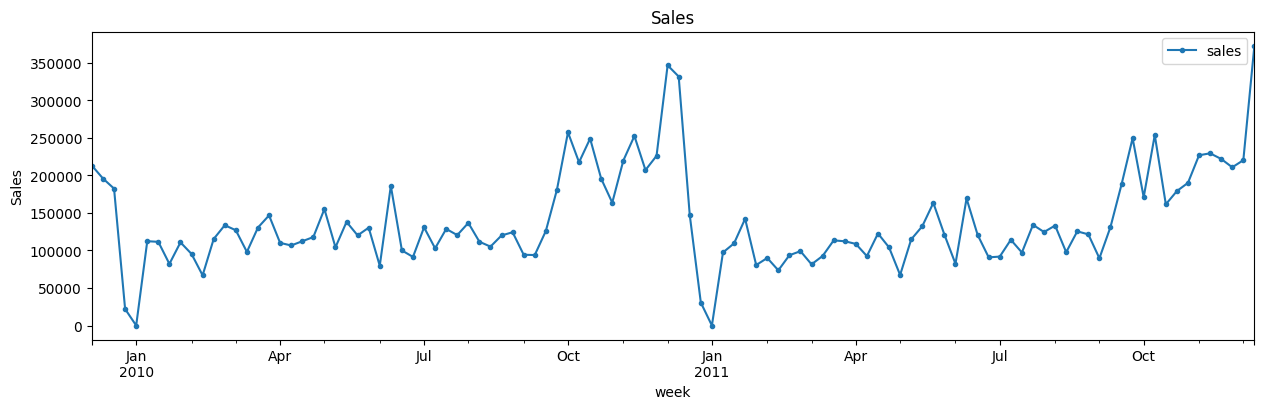

sales    0
dtype: int64


In [5]:
df_ = df.asfreq('1W')
df_imputed = df_.fillna(method='ffill')

ax = df_.plot(linestyle='-', marker='.', figsize=[15, 4])
df_imputed[df_.isnull()].plot(ax=ax, legend=None, marker='.', color='r')

plt.title('Sales')
plt.ylabel('Sales')
plt.show()

print(df_.isna().sum())

## Seasonality

Does the time series show any obvious seasonal pattern?

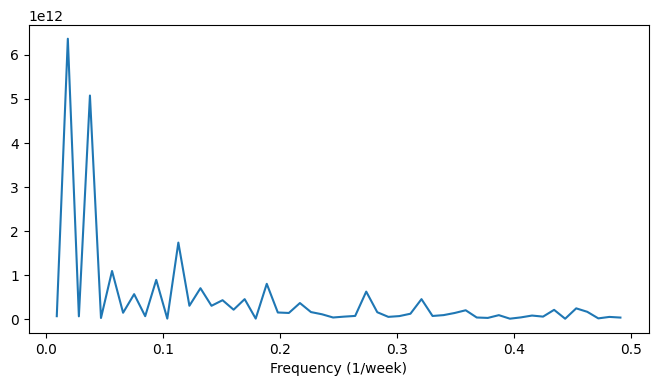

In [6]:
### FFT analysis
sales_fft = sp.fftpack.fft(df['sales'].values)
sales_psd = np.abs(sales_fft) ** 2
fftfreq = sp.fftpack.fftfreq(len(sales_psd), 1)
i = fftfreq > 0

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(fftfreq[i], sales_psd[i])
ax.set_xlabel('Frequency (1/week)')
plt.show()


[]

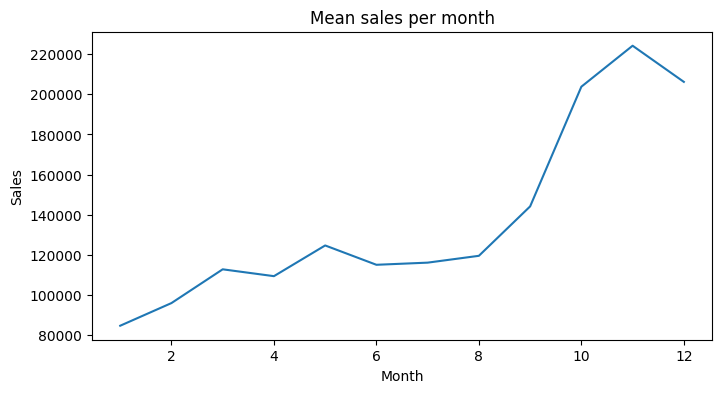

In [7]:
# Average sales per month.

month = df.index.month

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
df.groupby(month)['sales'].mean().plot(ax=ax)
ax.set_title('Mean sales per month')
ax.set_ylabel('Sales')
ax.set_xlabel('Month')
plt.plot()



[]

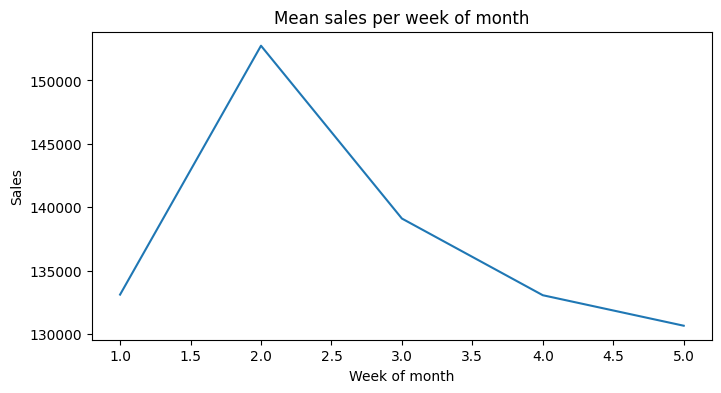

In [8]:
# Plot the average sales for every 1,2,3,4 and 5 week of a month.

wom = (df.index.day - 1) // 7 + 1

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
df.groupby(wom)['sales'].mean().plot(ax=ax)
ax.set_title('Mean sales per week of month')
ax.set_ylabel('Sales')
ax.set_xlabel('Week of month')
plt.plot()


# Feature engineering

Now, let's begin to tabularize the data.

In [9]:
# Datetime features
df['month'] = df.index.month
df['wom'] = (df.index.day -1) // 7 + 1
df.head()

# Cyclical features
cyclical = CyclicalFeatures(
    variables=["month", "wom"],
    drop_original=False,
)
df = cyclical.fit_transform(df)

In [10]:
# Lag features
df = df.merge(df["sales"].shift(freq="1W"), left_index=True, right_index=True, how="left", suffixes=['', '_lag_1'])

# Windowed features
for window in [2, 4]:
    tmp = df["sales"].rolling(window=window).agg(["mean", "max", "min"]).shift(1)
    tmp.columns = [f"sales_{window}_{func}" for func in ["mean", "max", "min"]]
    df = df.merge(tmp, left_index=True, right_index=True, how="left")

In [11]:
df.isnull().sum() / len(df)

sales           0.000000
month           0.000000
wom             0.000000
month_sin       0.000000
month_cos       0.000000
wom_sin         0.000000
wom_cos         0.000000
sales_lag_1     0.009434
sales_2_mean    0.018868
sales_2_max     0.018868
sales_2_min     0.018868
sales_4_mean    0.037736
sales_4_max     0.037736
sales_4_min     0.037736
dtype: float64

In [12]:
df.dropna(inplace=True)

## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

In [13]:
df.index.min(), df.index.max()

(Timestamp('2010-01-03 00:00:00'), Timestamp('2011-12-11 00:00:00'))

In [14]:
datecut = '2011-09-30'

X_train = df[df.index <= datecut].drop("sales", axis=1)
X_test = df[df.index > datecut].drop("sales", axis=1)
y_train = df[df.index <= datecut]["sales"].copy()
y_test = df[df.index > datecut]["sales"].copy()


## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

In [15]:
# Performance
print("train rmse: ", mse(y_train, X_train["sales_lag_1"], squared=False))
print("test rmse: ",  mse(y_test, X_test["sales_lag_1"], squared=False))

train rmse:  45844.30745262792
test rmse:  65327.34284108387


## Machine Learning

### Random Forest

In [16]:
rf_model = RandomForestRegressor(n_estimators=5, max_depth=1, random_state=42)
rf_model.fit(X_train, y_train)

# Performance
print("train rmse: ", mse(y_train, rf_model.predict(X_train), squared=False))
print("test rmse: ", mse(y_test, rf_model.predict(X_test), squared=False))

train rmse:  39142.597042428475
test rmse:  61796.84259089472


[]

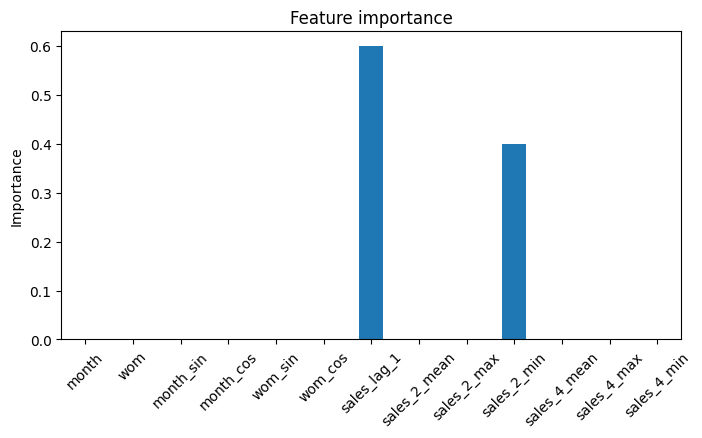

In [17]:
# Feature importance.
tmp = pd.Series(rf_model.feature_importances_)
tmp.index = X_train.columns

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
tmp.plot.bar(ax=ax, rot=45)
ax.set_title('Feature importance')
ax.set_ylabel('Importance')
#ax.set_xlabel('Week of month')
plt.plot()

### Lasso

In [18]:
lasso = Lasso(alpha=100, random_state=42)
lasso.fit(X_train, y_train)

# Performance
print("train rmse: ", mse(y_train, lasso.predict(X_train), squared=False))
print("test rmse: ", mse(y_test, lasso.predict(X_test), squared=False))

train rmse:  34836.61713978724
test rmse:  54602.946052290084


[]

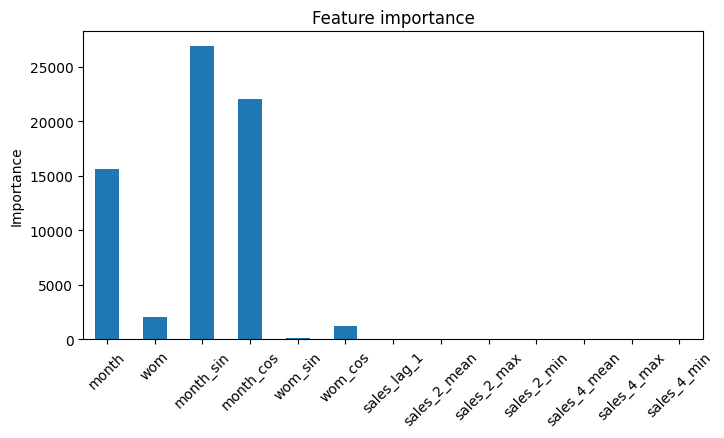

In [19]:
# Feature importance.
tmp = pd.Series(np.abs(lasso.coef_))
tmp.index = X_train.columns

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
tmp.plot.bar(ax=ax, rot=45)
ax.set_title('Feature importance')
ax.set_ylabel('Importance')
#ax.set_xlabel('Week of month')
plt.plot()